In [1]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdBwdLoss, MarginalChainLoss, EMLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
Data = Data_handling(
    dataset='dry-bean',
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

In [2]:
Data = Data_handling(
    dataset='mnist',
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets.shape)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df['target'].shape


torch.Size([10000, 10])


(60000,)

In [4]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z, w = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.34217728e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.34217728e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.35544320e-02 3.35544320e-02]
 ...
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  0.00000000e+00 2.04800000e-06]
 [2.04800000e-06 2.04800000e-06 2.04800000e-06 ... 2.04800000e-06
  2.04800000e-06 0.00000000e+00]
 [5.12000000e-07 5.12000000e-07 5.12000000e-07 ... 5.12000000e-07
  5.12000000e-07 5.12000000e-07]]
Generated z (noisy labels):
tensor([ 49, 848, 304,  ...,  25,  59, 129], dtype=torch.int32)
Generated w (multi-label matrix):
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]], 

Using device: cuda
Epoch 10/50: Train Loss: 0.0000, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: 4600.1706, Test Detached Loss: 4721.7386, Learning Rate: 0.010000, Epoch Time: 7.91 seconds
Epoch 20/50: Train Loss: 0.0000, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: 4600.1706, Test Detached Loss: 4721.7386, Learning Rate: 0.010000, Epoch Time: 7.75 seconds
Epoch 30/50: Train Loss: 0.0000, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: 4600.1706, Test Detached Loss: 4721.7386, Learning Rate: 0.010000, Epoch Time: 8.80 seconds
Epoch 40/50: Train Loss: 0.0000, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: 4600.1706, Test Detached Loss: 4721.7386, Learning Rate: 0.010000, Epoch Time: 10.06 seconds
Epoch 50/50: Train Loss: 0.0000, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: 4600.1706, Test Detached Loss: 4721.7386, Learning Rate: 0.010000, Epoch Time: 8.49 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  

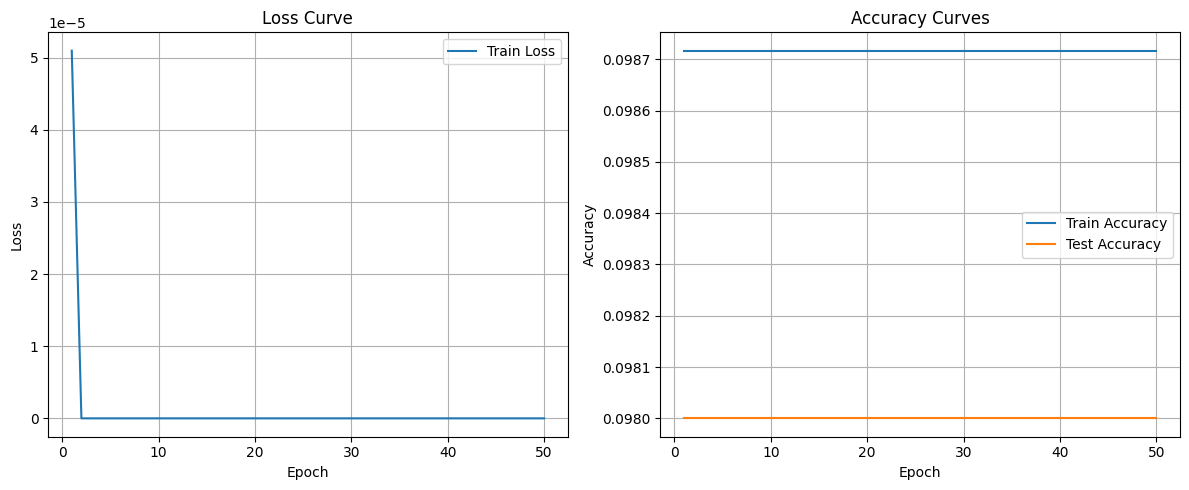

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[128, 64],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-2,
)
# 2. Training parameters
num_epochs = 50

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Epoch 10/50: Train Loss: 14.6867, Train Acc: 0.1022, Test Acc: 0.1010, Train Detached Loss: 2088.4157, Test Detached Loss: 2155.1084, Learning Rate: 0.010000, Epoch Time: 9.19 seconds
Epoch 20/50: Train Loss: 14.6867, Train Acc: 0.1022, Test Acc: 0.1010, Train Detached Loss: 2088.4157, Test Detached Loss: 2155.1084, Learning Rate: 0.010000, Epoch Time: 9.28 seconds
Epoch 30/50: Train Loss: 14.6867, Train Acc: 0.1022, Test Acc: 0.1010, Train Detached Loss: 2088.4157, Test Detached Loss: 2155.1084, Learning Rate: 0.010000, Epoch Time: 9.66 seconds
Epoch 40/50: Train Loss: 14.6867, Train Acc: 0.1022, Test Acc: 0.1010, Train Detached Loss: 2088.4157, Test Detached Loss: 2155.1084, Learning Rate: 0.010000, Epoch Time: 17.49 seconds
Epoch 50/50: Train Loss: 14.6867, Train Acc: 0.1022, Test Acc: 0.1010, Train Detached Loss: 2088.4157, Test Detached Loss: 2155.1084, Learning Rate: 0.010000, Epoch Time: 10.36 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_

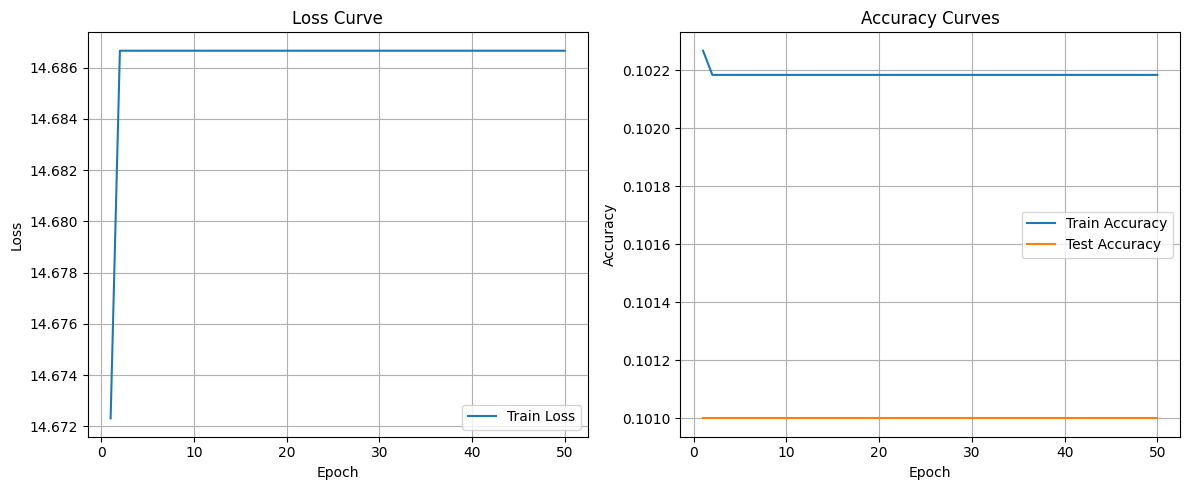

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[128, 64],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-2,
)
# 2. Training parameters
num_epochs = 50

em_loss = FwdBwdLoss(F = weakener.M, B = np.eye(weakener.d))

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Using device: cuda
Epoch 10/50: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: nan, Test Detached Loss: nan, Learning Rate: 0.010000, Epoch Time: 6.72 seconds
Epoch 20/50: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: nan, Test Detached Loss: nan, Learning Rate: 0.010000, Epoch Time: 7.26 seconds
Epoch 30/50: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: nan, Test Detached Loss: nan, Learning Rate: 0.010000, Epoch Time: 9.36 seconds
Epoch 40/50: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: nan, Test Detached Loss: nan, Learning Rate: 0.010000, Epoch Time: 7.80 seconds
Epoch 50/50: Train Loss: nan, Train Acc: 0.0987, Test Acc: 0.0980, Train Detached Loss: nan, Test Detached Loss: nan, Learning Rate: 0.010000, Epoch Time: 7.57 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0       1         NaN   0.098717     0.098                  NaN   
1      

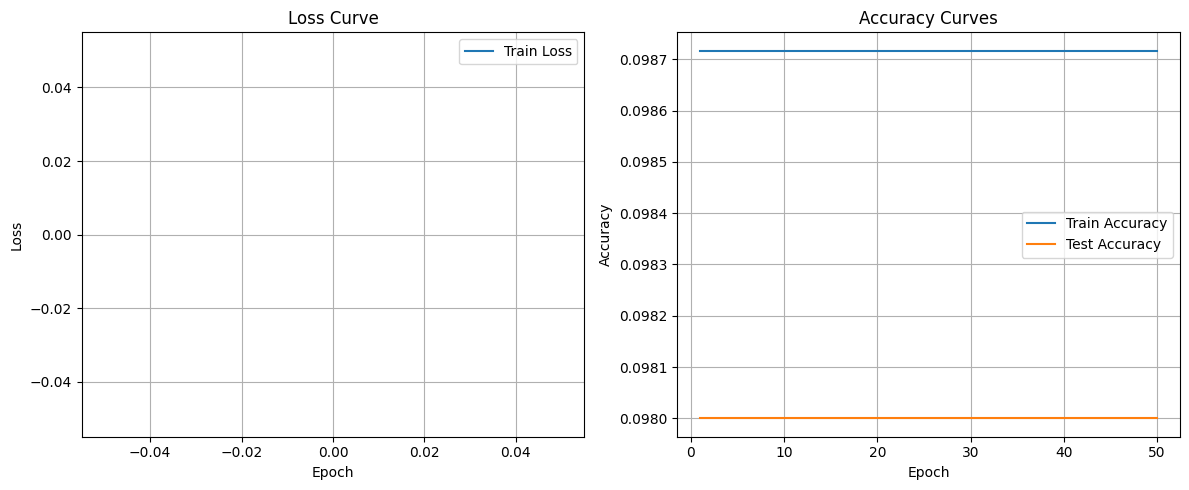

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[128, 64],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-2,
)
# 2. Training parameters
num_epochs = 50

em_loss = EMLoss(weakener.M)

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
losses.EMLoss(Weak.M)

In [14]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]
#df

In [2]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# fetch dataset 
dry_bean = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X = dry_bean.data.features 
y = np._core.ravel(dry_bean.data.targets)
y = le.fit_transform(y)  
print(y)


[5 5 5 ... 3 3 3]


In [ ]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df.head()

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1

,feature_0,feature_1,feature_2,feature_3,target
0,-3.5713,-12.49220,14.8881,-0.47027,"[0.0, 1.0]"
1,-2.4560,-0.24418,1.4041,-0.45863,"[0.0, 1.0]"
2,-1.1022,-5.83950,4.5641,0.68705,"[0.0, 1.0]"
3,3.0333,-2.59280,2.3183,0.30300,"[1.0, 0.0]"
4,-2.9915,-6.62580,8.6521,1.81980,"[0.0, 1.0]"


In [ ]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z, w = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.  0.8]
 [0.8 0. ]
 [0.2 0.2]]
Generated z (noisy labels):
tensor([0, 2, 0,  ..., 0, 0, 0], dtype=torch.int32)
Generated w (multi-label matrix):
tensor([[0., 1.],
        [1., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=torch.float64)
Inputs batch shape: torch.Size([64, 4])
Weak (partial) labels shape: torch.Size([64])
True one-hot labels shape: torch.Size([64, 2])
